# SMS Spam Collection Dataset

In [458]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import string
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))

#!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


## Read The Data

In [459]:
df =pd.read_csv('spam.csv', encoding='latin-1')
df['cleaned_SMS'] = ''


In [460]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,cleaned_SMS
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,


In [461]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "cleaned_SMS"], axis=1)
df = df.drop([], axis=1)
df2 = df.rename(columns={"v1":"y","v2":"SMS"})

In [462]:
df2.head(1)

,y,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."


In [463]:
df2.shape

(5572, 2)

In [464]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [465]:
df2.isna().sum()

y      0
SMS    0
dtype: int64

In [466]:
df2.SMS

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: SMS, Length: 5572, dtype: object

In [467]:
#Remove repatation 
df2.drop_duplicates(inplace=True)

## Preprocessing:

In [468]:
def clean_text(headline):
    le=WordNetLemmatizer()
    word_tokens=word_tokenize(headline)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
    cleaned_text=" ".join(tokens)
    return cleaned_text

In [469]:
# time taking
df2['headline_cleaned_text']=df2['SMS'].apply(clean_text)

In [470]:
#Convert All Text to LowerCase
df2.headline_cleaned_text=df2.headline_cleaned_text.str.lower()

In [471]:
#Remove Stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df2["headline_cleaned_text"] = df2["headline_cleaned_text"].apply(lambda text: remove_stopwords(text))

In [472]:
#Remove Punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df2["headline_cleaned_text"] = df2["headline_cleaned_text"].apply(lambda text: remove_punctuation(text))

In [473]:
#Removal of Rare words
from collections import Counter
cnt = Counter()
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df2["headline_cleaned_text"] = df2["headline_cleaned_text"].apply(lambda text: remove_rarewords(text))


In [474]:
df2.head(3)

,y,SMS,headline_cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,joking
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp final tkts 21st 2005 text...


In [475]:
df2.drop(['SMS'],axis=1,inplace=True)

In [476]:
df2.head()

,y,headline_cleaned_text
0,ham,jurong point crazy available bugis great world...
1,ham,joking
2,spam,free entry wkly comp final tkts 21st 2005 text...
3,ham,early already
4,ham,think go life around though


## Unsupervised Learning

### clustering (k-means)

In [477]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=950) # to play with. min_df,max_df,max_features etc...

In [478]:
vect_text=vect.fit_transform(df2['headline_cleaned_text'])

In [479]:
print(vect_text.shape)
print(vect_text)

(5169, 950)
  (0, 159)	0.4280769562440059
  (0, 935)	0.3542867022732795
  (0, 349)	0.28393600569159017
  (0, 119)	0.4280769562440059
  (0, 72)	0.38836166627912666
  (0, 198)	0.39205953327299153
  (0, 618)	0.350465483128694
  (2, 58)	0.2751913995703769
  (2, 649)	0.2705558638198081
  (2, 643)	0.27685185689170244
  (2, 662)	0.2691132133638781
  (2, 815)	0.191969115778234
  (2, 298)	0.2982126942337076
  (2, 177)	0.318891395478312
  (2, 924)	0.318891395478312
  (2, 265)	0.5813036323758812
  (2, 317)	0.1868690349827682
  (3, 46)	0.6386962189235316
  (3, 250)	0.7694589917161174
  (4, 825)	0.49311670263838464
  (4, 62)	0.435367890499476
  (4, 452)	0.4288104943149166
  (4, 341)	0.49899341385280027
  (4, 822)	0.36663040026436405
  (5, 10)	0.38001024082198237
  :	:
  (5163, 317)	0.209733899966256
  (5163, 349)	0.24470425941797985
  (5164, 116)	0.4166389088001628
  (5164, 251)	0.3509099196492098
  (5164, 516)	0.3215717609005344
  (5164, 187)	0.30067656955980315
  (5164, 853)	0.3602258739806543
  

In [480]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2,init='k-means++', max_iter=100,n_init=1)
model.fit(vect_text)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [481]:
df2['cluster']=model.labels_
df2.head(20)

,y,headline_cleaned_text,cluster
0,ham,jurong point crazy available bugis great world...,1
1,ham,joking,1
2,spam,free entry wkly comp final tkts 21st 2005 text...,1
3,ham,early already,1
4,ham,think go life around though,1
5,spam,freemsg darling week word back like still chgs...,1
6,ham,even brother like speak treat like aid patent,1
7,ham,request melle melle minnaminunginte nurungu ve...,1
8,spam,winner valued network customer selected receiv...,1
9,spam,mobile month entitled update latest colour mob...,1


In [482]:
clusters= df2.groupby('cluster')

In [483]:
test_0=df2[model.labels_==0]
test_0.shape

(833, 3)

In [484]:
print("Top terms per cluster:")
print('clusters 0:')
df2.loc[df2['cluster'] == 0].iloc[:, 1]

Top terms per cluster:
clusters 0:


10      home soon want talk stuff anymore tonight crie...
28                                 back packing know room
30              wait still clear sure sarcastic want live
36                                oops know roommate done
41      forget tell want need crave love sweet arabian...
                              ...                        
5537    want explicit sec ring 02073162414 costs 20pmi...
5544    taking derek taylor walmart back time done lea...
5549       know people wear shirt jumper belt know cribbs
5550                                      cool time think
5561                  dump heap decided come lowes boring
Name: headline_cleaned_text, Length: 833, dtype: object

In [485]:
print('clusters 1:')
df2.loc[df2['cluster'] == 1].iloc[:, 1]

clusters 1:


0       jurong point crazy available bugis great world...
1                                                  joking
2       free entry wkly comp final tkts 21st 2005 text...
3                                           early already
4                             think go life around though
                              ...                        
5567    time tried contact å£750 pound prize claim eas...
5568                                 going esplanade home
5569                                 pity mood suggestion
5570    bitching acted like interested buying somethin...
5571                                       rofl true name
Name: headline_cleaned_text, Length: 4336, dtype: object

In [486]:
df2['Target'] = df2['cluster'].apply(lambda x: 'ham' if x == 0 else 'spam')
df2.head(10)

,y,headline_cleaned_text,cluster,Target
0,ham,jurong point crazy available bugis great world...,1,spam
1,ham,joking,1,spam
2,spam,free entry wkly comp final tkts 21st 2005 text...,1,spam
3,ham,early already,1,spam
4,ham,think go life around though,1,spam
5,spam,freemsg darling week word back like still chgs...,1,spam
6,ham,even brother like speak treat like aid patent,1,spam
7,ham,request melle melle minnaminunginte nurungu ve...,1,spam
8,spam,winner valued network customer selected receiv...,1,spam
9,spam,mobile month entitled update latest colour mob...,1,spam


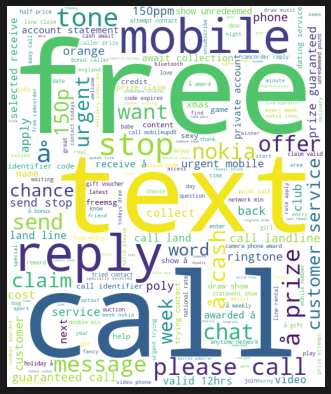

In [516]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
#Top word for spam sms
wordcloud = WordCloud(background_color="white",width=500, height=600).generate(' '.join(text for text in df2.loc[df2['y'] == 'spam', 'headline_cleaned_text']))
plt.figure( figsize=(8,7), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off");
plt.savefig('pic4',dpi=250)

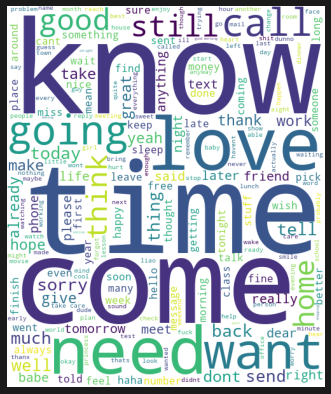

In [515]:
#Top word for ham sms
wordcloud = WordCloud(background_color="white",width=500, height=600).generate(' '.join(text for text in df2.loc[df2['y'] == 'ham', 'headline_cleaned_text']))
plt.figure( figsize=(8,7), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off");
plt.savefig('pic3',dpi=250)

In [489]:
#creat a new column to detect how long the text messages are
df2['length'] = df2['headline_cleaned_text'].apply(len)
df2.head()

,y,headline_cleaned_text,cluster,Target,length
0,ham,jurong point crazy available bugis great world...,1,spam,64
1,ham,joking,1,spam,6
2,spam,free entry wkly comp final tkts 21st 2005 text...,1,spam,104
3,ham,early already,1,spam,13
4,ham,think go life around though,1,spam,27


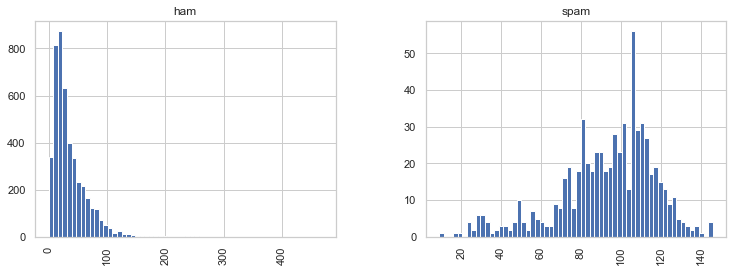

In [514]:
df2.hist(column='length',by='y',bins=60,figsize=(12,4));
plt.savefig('pic2',dpi=250)

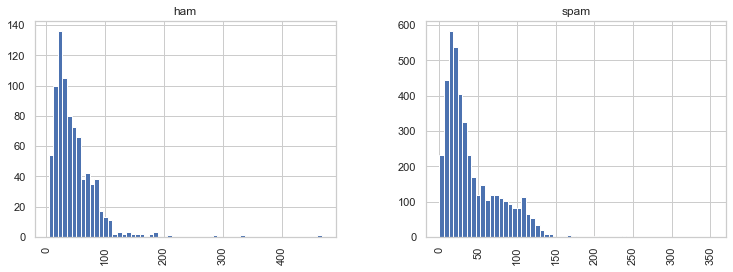

In [491]:
df2.hist(column='length',by='Target',bins=60,figsize=(12,4));

## supervised Learning

In [492]:
#split X and y into training and testing sets
X = df2['headline_cleaned_text']
y = df2['y']

In [493]:
# Bag of Word
cvec=CountVectorizer()
cvdf=cvec.fit_transform(X)

In [494]:
cvdf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [495]:
# Imbalanced data
# Apply SMOTE
sm=SMOTE()
x_sm,y_sm=sm.fit_resample(cvdf,y)

In [496]:
y_sm.value_counts()

ham     4516
spam    4516
Name: y, dtype: int64

In [497]:
#split X and y into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.2,random_state=0)

In [498]:
#### Naive Bayes
naiv=MultinomialNB()
naiv.fit(x_train,y_train)
y_naiv_pred=naiv.predict(x_test)
accuracy_score(y_test,y_naiv_pred)

0.8583287216380742

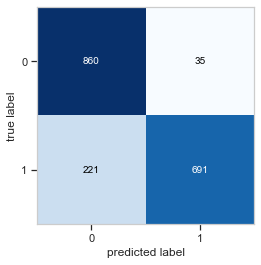

In [499]:
mat1=confusion_matrix(y_test, y_naiv_pred)
plot_confusion_matrix(conf_mat=mat1);

In [500]:
print(classification_report(y_test,y_naiv_pred))

              precision    recall  f1-score   support

         ham       0.80      0.96      0.87       895
        spam       0.95      0.76      0.84       912

    accuracy                           0.86      1807
   macro avg       0.87      0.86      0.86      1807
weighted avg       0.87      0.86      0.86      1807



In [501]:
##XGBoost
xgb= XGBClassifier()
xgb.fit(x_train,y_train)
y_xgb_pred=xgb.predict(x_test)
accuracy_score(y_test,y_xgb_pred)

[20:11:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9845047039291643

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

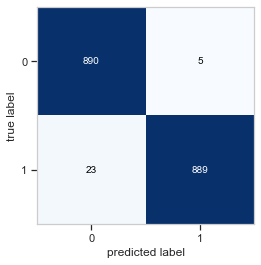

In [502]:
mat2=confusion_matrix(y_test, y_xgb_pred)
plot_confusion_matrix(conf_mat=mat2)

In [503]:
print(classification_report(y_test,y_xgb_pred))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       895
        spam       0.99      0.97      0.98       912

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



In [504]:
#Random Forest
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
y_rf_pred=rf.predict(x_test)
accuracy_score(y_test,y_rf_pred)

0.9131156613171002

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

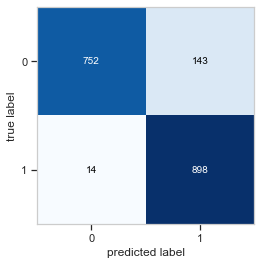

In [505]:
mat3=confusion_matrix(y_test, y_rf_pred)
plot_confusion_matrix(conf_mat=mat3)

In [506]:
print(classification_report(y_test,y_rf_pred))

              precision    recall  f1-score   support

         ham       0.98      0.84      0.91       895
        spam       0.86      0.98      0.92       912

    accuracy                           0.91      1807
   macro avg       0.92      0.91      0.91      1807
weighted avg       0.92      0.91      0.91      1807



In [507]:
#SVM Classification
svm=SVC(kernel='linear')
svm.fit(x_train,y_train)
y_pred=svm.predict(x_test)
accuracy_score(y_test,y_pred)


0.9169894853348091

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

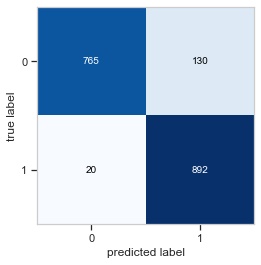

In [508]:
mat4=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat4)

In [509]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.97      0.85      0.91       895
        spam       0.87      0.98      0.92       912

    accuracy                           0.92      1807
   macro avg       0.92      0.92      0.92      1807
weighted avg       0.92      0.92      0.92      1807



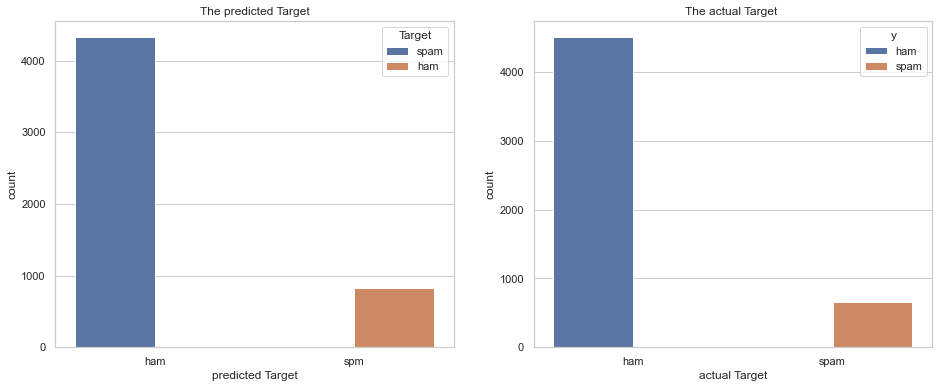

In [513]:
fig, ax =plt.subplots(1,2,figsize=(14,6))
sns.countplot(x=df2["Target"],hue=df2["Target"],ax=ax[0])
sns.countplot(x=df2["y"],hue=df2["y"],ax=ax[1])
ax[0].set_title("The predicted Target")
ax[1].set_title("The actual Target ")
ax[0].set_xlabel("predicted Target")
ax[1].set_xlabel("actual Target")
ax[0].set_xticklabels(["ham","spm"])
ax[1].set_xticklabels(["ham","spam"])
fig.show()
plt.savefig('pic1',dpi=250)

In [511]:
# The real target in the dataset
df2.y.value_counts()

ham     4516
spam     653
Name: y, dtype: int64

In [512]:
# The predicted target
df2.Target.value_counts()

spam    4336
ham      833
Name: Target, dtype: int64

__________

### This Work Done By Group:

- ABDULRAHIM ALSHEHRI
- ELHAM ALZAHRANI
- NOUF ALKHALDI